In [1]:
import matplotlib.pyplot as plt
import numpy as np

\begin{align}
\ddot{x}(t) + 2\beta\omega_0\dot{x}(t) + \omega_0^2x(t) = 0
\end{align}

Ansatz, $x = \exp(\gamma t)$; $\gamma = -\omega_0\left[\beta \pm i\sqrt{1 - \beta^2}\right]$

In [2]:
def damped_sho(t, omega_0, beta, shift=0):
    # beta less than 1 for underdamped
    envel = beta * omega_0
    osc = np.sqrt(1 - beta**2) * omega_0
    tau = t - shift
    data = np.exp(-envel * tau) * np.cos(osc * tau)
    data[tau < 0] = 0  # assume oscillator starts at tau = 0
    return data

## Plot

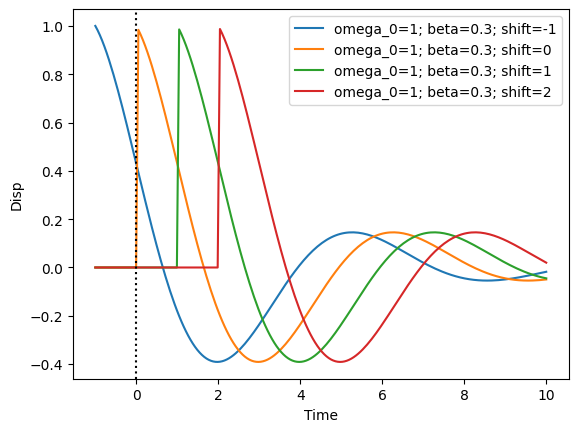

In [3]:
omega_0 = 1
beta = 0.3

t_vals = np.linspace(-1, 10, 200)
for shift in [-1, 0, 1, 2]:
    x_vals = damped_sho(t_vals, omega_0=omega_0, beta=beta, shift=shift)
    plt.plot(t_vals, x_vals, label=f"{omega_0=}; {beta=}; {shift=}")
plt.xlabel("Time")
plt.ylabel("Disp")
plt.axvline(x=0, linestyle='dotted', color='black')
plt.legend()

In [4]:
injection_parameters = dict(omega_0=omega_0, beta=beta, shift=2)

In [5]:
num_points = 200
t_vals = np.linspace(-1, 10, num_points)

In [6]:
sigma = 0.1

In [7]:
data = damped_sho(t_vals, **injection_parameters) + np.random.normal(0, sigma, t_vals.size)

Text(0, 0.5, 'y')

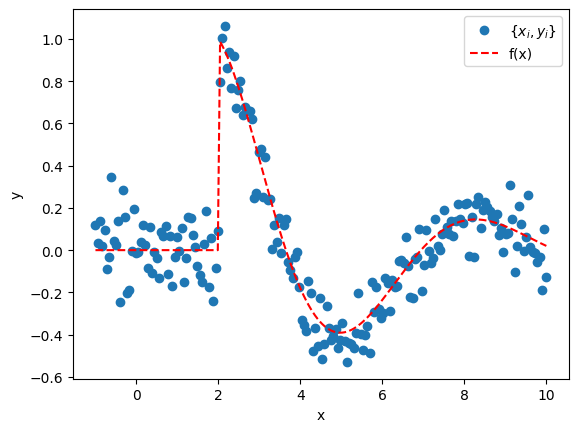

In [8]:
fig, ax = plt.subplots()
ax.plot(t_vals, data, 'o', label='$\\{x_i, y_i\\}$')
ax.plot(t_vals, damped_sho(t_vals, **injection_parameters), '--r', label='f(x)')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')

In [9]:
import bilby
from bilby.core.prior import Uniform, DeltaFunction

## Prior for parameters

In [10]:
priors = dict()

priors['omega_0'] = Uniform(0.1, 2, name='omega_0', latex_label='$\omega_0$')
priors['beta'] = Uniform(0, 0.5, name='beta', latex_label='$\\beta$')
priors['shift'] = Uniform(-4, 4, name='shift', latex_label='$\Delta\;t$')

## Likelihood

In [11]:
from bilby.core.likelihood import GaussianLikelihood

log_l = GaussianLikelihood(t_vals, data, damped_sho, sigma=sigma)

In [12]:
# result = bilby.run_sampler(
#     likelihood=log_l, priors=priors, sampler='dynesty',
#     nlive=300, npool=4, save=False, clean=True,
#     injection_parameters=injection_parameters,
#     outdir='./damped_sho',
#     label='damped_sho'
# )

In [13]:
# result.plot_corner(priors=True)

# Train embedding space first

The aim is to make the network be agnostic to shift in time. Train embedding space to cluster shifts in intercept value.

In [14]:
from IPython.display import clear_output
from time import sleep

In [15]:
def get_data(omega_0=None, beta=None, shift=None, num_points=1):
    """Sample omega, beta, shift and return a batch of data with noise"""
    omega_0 = priors['omega_0'].sample() if omega_0 is None else omega_0
    beta = priors['beta'].sample() if beta is None else beta
    shift = priors['shift'].sample() if shift is None else shift
    t_vals = np.linspace(-1, 10, num_points)
    y = damped_sho(t_vals, omega_0=omega_0, beta=beta, shift=shift)
    y += sigma*np.random.normal(size=y.size)

    return t_vals, y, omega_0, beta, shift

# Add augmentation

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter

In [17]:
num_simulations = 10000
theta_vals = []
data_vals = []
for ii in range(num_simulations):
    t_vals, y, omega, beta, shift = get_data(num_points=200, shift=0)
    data_vals.append(y)
    theta_vals.append([omega, beta, shift])

In [18]:
theta_vals = np.array(theta_vals)
data_vals = np.array(data_vals)

In [19]:
theta_vals[0]

array([1.47529616, 0.41619342, 0.        ])

In [20]:
class DataGenerator(Dataset):
    def __len__(self):
        return num_simulations

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # augment the data to have several shifted intercepts
        theta, data = self.augment(idx)

        return (
            torch.from_numpy(theta).to(torch.float32),
            torch.from_numpy(data).to(torch.float32)
        )

    def augment(self, idx):
        repeats = 30  # just a choice, can be different
        omega = theta_vals[idx][0]
        beta = theta_vals[idx][1]
        theta_aug_vals, data_aug_vals = [], []
        for _ in range(repeats):
            # augment every instance of natural freq and damping with several shifts
            t_val, y_val, omega_0, beta, shift = get_data(
                omega_0=omega, beta=beta, shift=None,
                num_points=num_points
            )
            data_aug_vals.append(y_val)
            theta_aug_vals.append([omega_0, beta, shift])
        return np.array(theta_aug_vals), np.array(data_aug_vals)

In [21]:
dataset = DataGenerator()

In [22]:
dataset[0][1].shape

torch.Size([30, 200])

Text(0.5, 1.0, 'Augmented sample; Omega_0 = 1.7; Beta = 0.2')

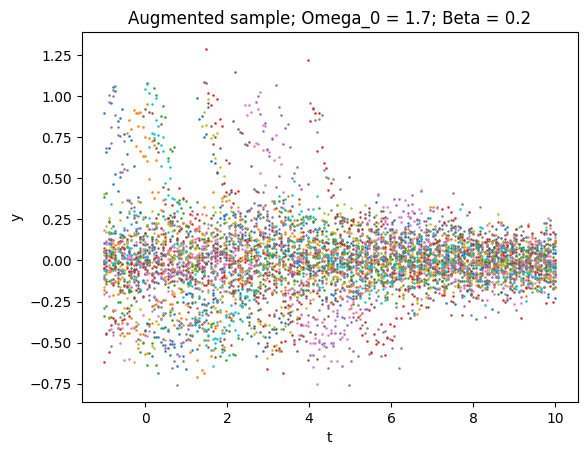

In [23]:
t, d = dataset.augment(4)

fig, ax = plt.subplots()

for (omega, beta, shift), points in zip(t, d):
    ax.plot(t_vals, points, 'o', markersize=0.8, label='$\\{x_i, y_i\\}$')
ax.set_xlabel('t')
ax.set_ylabel('y')
ax.set_title(f"Augmented sample; Omega_0 = {t[0][0]:.1f}; Beta = {t[0][1]:.1f}")

In [24]:
train_set_size = int(0.8 * num_simulations)
val_set_size = int(0.1 * num_simulations)
test_set_size = int(0.1 * num_simulations)

train_data, val_data, test_data = torch.utils.data.random_split(
    dataset, [train_set_size, val_set_size, test_set_size])

In [25]:
train_data_loader = DataLoader(
    train_data, batch_size=20,
    shuffle=True
)

val_data_loader = DataLoader(
    val_data, batch_size=20,
    shuffle=True
)

test_data_loader = DataLoader(
    test_data, batch_size=1,
    shuffle=False
)

In [26]:
for theta, data in train_data_loader:
    break

In [27]:
theta.shape, data.shape

(torch.Size([20, 30, 3]), torch.Size([20, 30, 200]))

## Define similarity loss

In [28]:
# implemented from https://github.com/violatingcp/codec
class VICRegLoss(nn.Module):

    def __init__(self, lambda_param=1, mu_param=1,
                 nu_param=20, sort_tolerance=1.0,
                 sort_reg='l2'):
        
        super().__init__()
        self.lambda_param = lambda_param
        self.mu_param = mu_param
        self.nu_param = nu_param
        self.tolerance = sort_tolerance
        self.reg = sort_reg

    def forward(self, x, y):
        repr_loss = F.mse_loss(x, y)

        x = x - x.mean()
        y = y - y.mean()
        N = x.size(0)
        D = x.size(1)
        
        std_x = torch.sqrt(x.var() + 0.0001)
        std_y = torch.sqrt(y.var() + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        x = (x-x.mean())/x.std()
        y = (y-y.mean())/y.std()

        cov_x = (x.T @ x)
        cov_y = (y.T @ y)
        cov_loss = self.off_diagonal(cov_x).pow_(2).sum().div(D)
        cov_loss += self.off_diagonal(cov_y).pow_(2).sum().div(D)

        return repr_loss + cov_loss + std_loss

    def off_diagonal(self,x):
        n, m = x.shape
        assert n == m
        return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

In [29]:
vicreg_loss = VICRegLoss()

In [30]:
class SimilarityEmbedding(nn.Module):
    """Simple Dense embedding"""
    def __init__(self, num_hidden_layers=1, activation=torch.relu):
        super().__init__()
        self.num_hidden_layers = num_hidden_layers
        self.first_layer = nn.Linear(num_points, 20)
        self.layers = nn.ModuleList([nn.Linear(20, 20) for _ in range(num_hidden_layers)])
        self.final_layer = nn.Linear(20, 3)
        self.activation = activation

    def forward(self, x):
        x = self.first_layer(x)
        x = self.activation(x)
        for layer in self.layers:
            x = layer(x)
            x = self.activation(x)
        x = self.final_layer(x)
        return x

In [31]:
similarity_embedding = SimilarityEmbedding(num_hidden_layers=5)

optimizer = optim.Adam(similarity_embedding.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, total_steps=5)

In [32]:
data.shape

torch.Size([20, 30, 200])

In [33]:
similarity_embedding(data).shape

torch.Size([20, 30, 3])

In [34]:
similarity_embedding(data)[0].shape

torch.Size([30, 3])

In [35]:
# similarity_embedding_model_path = './_sho_similarity_embedding.pt'
# torch.save(similarity_embedding.state_dict(), similarity_embedding_model_path)
# similarity_embedding.load_state_dict(torch.load(similarity_embedding_model_path))

In [36]:
def train_one_epoch(epoch_index, tb_writer):
    running_sim_loss = 0.
    last_sim_loss = 0.

    for idx, val in enumerate(train_data_loader, 1):
        augmented_theta, augmented_data = val
        similar_embedded_values = similarity_embedding(augmented_data)
        #similar_embedded_values = similar_embedded_values.sum(axis=0)  # sum along batch dimension

        #similar_embedding_loss = 0
        #x = similar_embedded_values[0]
        #for elem in range(1, len(similar_embedded_values)):
        #    y = similar_embedded_values[elem]
        #    similar_embedding_loss += vicreg_loss(x, y)

        for repeats in similar_embedded_values:
            similar_embedding_loss = 0
            x = repeats[0].reshape(1, 3)
            for elem in range(1, len(repeats)):
                y = repeats[elem].reshape(1, 3)
                similar_embedding_loss += vicreg_loss(x, y)
        optimizer.zero_grad()
        similar_embedding_loss.backward()
        optimizer.step()
        # Gather data and report
        running_sim_loss += similar_embedding_loss.item()
        if idx % 100 == 0:
            last_sim_loss = running_sim_loss / 100
            print(' Avg. train loss/batch after {} batches = {:.4f}'.format(idx, last_sim_loss))
            tb_x = epoch_index * len(train_data_loader) + idx
            tb_writer.add_scalar('SimLoss/train', last_sim_loss, tb_x)
            running_sim_loss = 0.
    return last_sim_loss


def val_one_epoch(epoch_index, tb_writer):
    running_sim_loss = 0.
    last_sim_loss = 0.

    for idx, val in enumerate(val_data_loader, 1):
        augmented_theta_val, augmented_data_val = val
        similar_embedded_values = similarity_embedding(augmented_data_val)
        #similar_embedded_values = similar_embedded_values.sum(axis=0)  # sum along batch dimension

        for repeats in similar_embedded_values:
            similar_embedding_loss = 0
            x = repeats[0].reshape(1, 3)
            for elem in range(1, len(repeats)):
                y = repeats[elem].reshape(1, 3)
                similar_embedding_loss += vicreg_loss(x, y)

        running_sim_loss += similar_embedding_loss.item()
        if idx % 50 == 0:
            last_sim_loss = running_sim_loss / 50
            tb_x = epoch_index * len(val_data_loader) + idx + 1
            tb_writer.add_scalar('SimLoss/val', last_sim_loss, tb_x)
            tb_writer.flush()
            running_sim_loss = 0.
    tb_writer.flush()
    return last_sim_loss

In [37]:
writer = SummaryWriter("sho_linear_embedding", comment="Similarity with LR=1e-3", flush_secs=5)
epoch_number = 0

In [38]:
%%time
# UNCOMMENT AND RUN TO TRAIN FROM SCRATCH
EPOCHS = 5

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    # Gradient tracking
    similarity_embedding.train(True)
    avg_train_loss = train_one_epoch(epoch_number, writer)
    
    # no gradient tracking, for validation
    similarity_embedding.train(False)
    avg_val_loss = val_one_epoch(epoch_number, writer)
    
    print(f"Train/Val Sim Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")

    epoch_number += 1
    scheduler.step()

EPOCH 1:
 Avg. train loss/batch after 100 batches = 50.9439
 Avg. train loss/batch after 200 batches = 38.7063
 Avg. train loss/batch after 300 batches = 38.6773
 Avg. train loss/batch after 400 batches = 38.6682
Train/Val Sim Loss after epoch: 38.6682/38.6674
EPOCH 2:
 Avg. train loss/batch after 100 batches = 38.6673
 Avg. train loss/batch after 200 batches = 38.6672
 Avg. train loss/batch after 300 batches = 38.6670
 Avg. train loss/batch after 400 batches = 38.6670
Train/Val Sim Loss after epoch: 38.6670/38.6669
EPOCH 3:
 Avg. train loss/batch after 100 batches = 38.6669
 Avg. train loss/batch after 200 batches = 38.6669
 Avg. train loss/batch after 300 batches = 38.6668
 Avg. train loss/batch after 400 batches = 38.6668
Train/Val Sim Loss after epoch: 38.6668/38.6668
EPOCH 4:
 Avg. train loss/batch after 100 batches = 38.6668
 Avg. train loss/batch after 200 batches = 38.6668
 Avg. train loss/batch after 300 batches = 38.6668
 Avg. train loss/batch after 400 batches = 38.6668
Trai

## See embedded space

In [39]:
similarity_embedding.train(False)

similarity_outputs_1 = []

for idx, (theta_test, data_test) in enumerate(test_data):
    if not ((theta_test.T[0][0] < 0.5) and (theta_test.T[0][0] > 0.2)):
        continue
    with torch.no_grad():
        similarity_output = similarity_embedding(data_test)
    similarity_outputs_1.append(similarity_output.numpy())

similarity_outputs_2 = []

for idx, (theta_test, data_test) in enumerate(test_data):
    if not ((theta_test.T[0][0] < 1.61) and (theta_test.T[0][0] > 1.49)):
        continue
    with torch.no_grad():
        similarity_output = similarity_embedding(data_test)
    similarity_outputs_2.append(similarity_output.numpy())

In [40]:
similarity_outputs_1 = np.array(similarity_outputs_1)
similarity_outputs_2 = np.array(similarity_outputs_2)

In [41]:
similarity_outputs_1.shape

(165, 30, 3)

### See projections of different $\omega_0$ and $\beta$ values

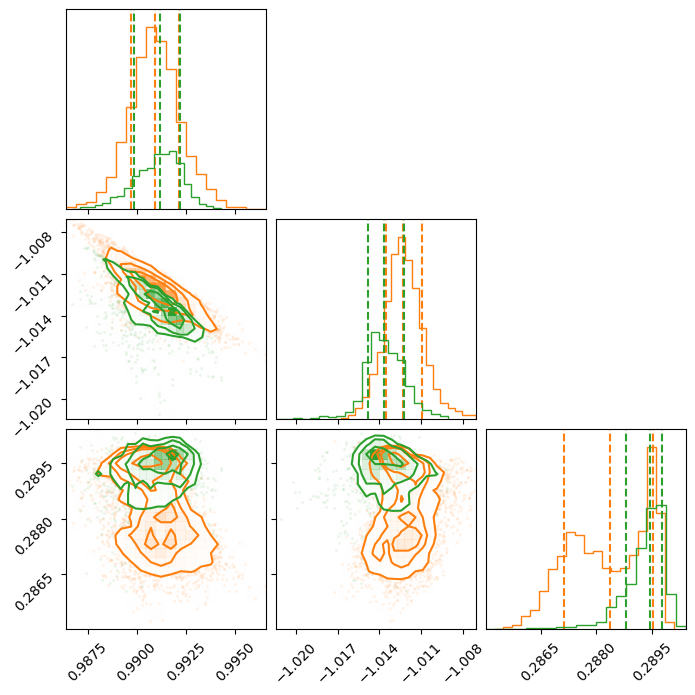

In [42]:
import corner

figure = corner.corner(
    similarity_outputs_1.reshape((similarity_outputs_1.shape[0]*similarity_outputs_1.shape[1], 3)),
    quantiles=[0.16, 0.5, 0.84], color="C1"
)

figure = corner.corner(
    similarity_outputs_2.reshape((similarity_outputs_2.shape[0]*similarity_outputs_2.shape[1], 3)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C2"
)


# Freeze weights, used as embedding network in MAF

In [ ]:
import corner

from nflows.distributions import StandardNormal
from nflows.flows import Flow
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms import CompositeTransform, RandomPermutation

import nflows.utils as torchutils

In [ ]:
num_transforms = 5
num_blocks = 4
hidden_features = 50

# context_features = similarity_embedding(data[:,0,:])[-1].numel()
context_features = similarity_embedding(data)[-1].numel()

base_dist = StandardNormal([3])

transforms = []
for _ in range(num_transforms):
    block = [
        MaskedAffineAutoregressiveTransform(
            features=3,  # 3-dim posterior
            hidden_features=hidden_features,
            context_features=context_features,
            num_blocks=num_blocks,
            activation=torch.tanh,
            use_batch_norm=False,
            use_residual_blocks=True,
            dropout_probability=0.01
        ),
        RandomPermutation(features=3)
    ]
    transforms += block

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist, similarity_embedding)

In [ ]:
# similarity_embedding(data)[-1].numel()

In [ ]:
# data[:,0,:].shape

In [ ]:
# similarity_embedding(data[:,0,:])[-1].numel()

In [ ]:
# flow_model_path = './sho_flow_model_path.pt'
# torch.save(flow.state_dict(), flow_model_path)
# flow.load_state_dict(torch.load(flow_model_path))

# Train/Validate

In [ ]:
num_augmentations = 10

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for idx, val in enumerate(train_data_loader, 1):
        augmented_theta, augmented_data = val

        loss = 0
        for ii in range(num_augmentations):
            theta = augmented_theta[:,ii,:]
            data = augmented_data[:,ii,:]

            flow_loss = -flow.log_prob(theta, context=data).sum()

            optimizer.zero_grad()
            flow_loss.backward()
            optimizer.step()
            
            loss += flow_loss.item()

        running_loss += loss/num_augmentations
        if idx % 100 == 0:
            last_loss = running_loss / 100 # avg loss
            print(' Avg. train loss/batch after {} batches = {:.4f}'.format(idx, last_loss))
            tb_x = epoch_index * len(train_data_loader) + idx
            tb_writer.add_scalar('Flow Loss/train', last_loss, tb_x)
            tb_writer.flush()
            running_loss = 0.
    return last_loss


def val_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for idx, val in enumerate(val_data_loader, 1):
        augmented_theta, augmented_data = val
        loss = 0
        for ii in range(num_augmentations):
            theta = augmented_theta[:,ii,:]
            data = augmented_data[:,ii,:]

            flow_loss = -flow.log_prob(theta, context=data).sum()
            loss += flow_loss.item()

        running_loss += loss/num_augmentations
        if idx % 50 == 0:
            last_loss = running_loss / 50
            tb_x = epoch_index * len(val_data_loader) + idx + 1
            tb_writer.add_scalar('Flow Loss/val', last_loss, tb_x)

            tb_writer.flush()
            running_loss = 0.
    tb_writer.flush()
    return last_loss

In [ ]:
optimizer = optim.Adam(flow.parameters(), lr=1e-3)

scheduler_1 = optim.lr_scheduler.ConstantLR(optimizer, total_iters=5)
scheduler_2 = optim.lr_scheduler.OneCycleLR(optimizer, total_steps=20, max_lr=1e-3)
scheduler_3 = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

scheduler = optim.lr_scheduler.SequentialLR(
    optimizer, schedulers=[scheduler_1, scheduler_2, scheduler_3], milestones=[5, 20])

In [ ]:
writer = SummaryWriter("sho_flow_conv_embedding", comment="With LR=1e-3", flush_secs=5)
epoch_number = 0

In [ ]:
%%time
# UNCOMMENT AND RUN TO TRAIN FROM SCRATCH
EPOCHS = 50

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    # Gradient tracking
    flow.train(True)
    # flow._embedding_net.train(False)
    # no gradient tracking for embedding layer
    for name, param in flow._embedding_net.named_parameters():
        param.requires_grad = False

    avg_train_loss = train_one_epoch(epoch_number, writer)
    
    # no gradient tracking, for validation
    flow.train(False)
    avg_val_loss = val_one_epoch(epoch_number, writer)
    
    print(f"Train/Val flow Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")

    epoch_number += 1
    scheduler.step()

# Check on test data

In [ ]:
import pandas as pd

def cast_as_bilby_result(samples, truth):
    injections = dict.fromkeys(injection_parameters)
    injections['omega_0'] = float(truth.numpy()[0])
    injections['beta'] = float(truth.numpy()[1])

    posterior = dict.fromkeys(injection_parameters)
    samples_numpy = samples.numpy()
    posterior['omega_0'] = samples_numpy.T[0].flatten()
    posterior['beta'] = samples_numpy.T[1].flatten()
    posterior = pd.DataFrame(posterior)
    
    return bilby.result.Result(
        label="test_data",
        injection_parameters=injections,
        posterior=posterior,
        search_parameter_keys=list(injections.keys()),
        priors=priors
    )

## Posterior

In [ ]:
def live_plot_samples(samples, truth):
    clear_output(wait=True)
    sleep(1)
    figure = corner.corner(
        samples.numpy(), quantiles=[0.16, 0.5, 0.84],
        show_titles=True, labels=["omega_0", "beta", "shift"],
        truth=truth
    )

    corner.overplot_lines(figure, truth, color="C1")
    corner.overplot_points(figure, truth[None], marker="s", color="C1")

In [ ]:
for idx, (theta_test, data_test) in enumerate(test_data):
    if idx % 10 !=0: continue 
    with torch.no_grad():
        samples = flow.sample(5000, context=data_test[0].reshape((1, 200)))
    live_plot_samples(samples[0], theta_test[0])
    plt.show()

In [ ]:
theta_test[0]

# PP plot

In [ ]:
results = []
for idx, (theta_test, data_test) in enumerate(test_data):
    with torch.no_grad():
        samples = flow.sample(3000, context=data_test[0].reshape((1, 200)))
    results.append(
        cast_as_bilby_result(samples, theta_test[0]))

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bilby.result.make_pp_plot(results, save=False, keys=['omega_0', 'beta'])